# Voronoi Binning Example

Isaac Cheng - December 2021

Based on the [IC3392 notebook](../galaxies/IC3392/IC3392.ipynb).

## Voronoi (adaptive) binning procedure

We wish to Voronoi bin our image such that each bin has a signal-to-noise ratio (SNR) of
at least 30. The difficulty lies in:
1. Ensuring the *exact same* Voronoi binning pattern occurs across all optical bands
2. Reducing the runtime of Voronoi binning for large images

To solve item #1, we simply choose the band with the lowest SNR---our "reference
band"---and bin this band to an SNR of 50. We then take the resulting Voronoi tesselation
and apply it to the other bands. From testing, this SNR target of 50 in the reference band
results in Voronoi bins that have SNRs $>=30$ across all bands. At the end of this
notebook, we check the number of pixels (not the number of bins) to see how many do not
satisfy this requirement. In the lookup table notebook, we check to see how many Voronoi
bins do not satisfy this requirement.

If there are any bins that do not meet our SNR threshold, they are usually very close to
reaching it (e.g., SNR of 25--29) and these bins are located near the edges of the image
(a direct consequence of the Voronoi binning algorithm). Keep in mind that the SNR
requirement of 30 is not a strict cutoff, so these bins should be okay to use. IIRC, in
almost all cases, less than 2% of bins do not make the SNR threshold (typically only
fractions of a percent, if any, fail the SNR requirement).

Regarding difficulty #2, we use a `numba`-compiled version of vorbin to speed up the
Voronoi binning algorithm.


In [1]:
# 
# Switch directories to folder for galaxy.
# Will contain relevant pickle files for the galaxy
# 
GALAXY = "IC3392"  # change this to the galaxy you want to Voronoi bin
GALPATH = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{GALAXY}/"  # change this path
%cd "$GALPATH"
# 
import astropy.units as u
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")  # change this path
import fits_utils as fu
import fast_vorbin as fv
# 
GALDIST = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty

/arc/home/IsaacCheng/coop_f2021/galaxies/IC3392


In [2]:
# 
# Just in case, run Voronoi-binning with small sample first to check it is working and to
# JIT-compile numba functions
# 
tmpnumpx = 200
tmpx = np.arange(1, tmpnumpx + 1).astype(int)
tmpy = np.arange(1, tmpnumpx + 1).astype(int)
tmpx, tmpy = np.meshgrid(tmpx, tmpy)
tmpsig = np.full(tmpx.size, 0.5)
tmpnoise = np.full(tmpx.size, 1.0)
# 
_ = fv.voronoi_2d_binning(
    tmpx.flatten(),
    tmpy.flatten(),
    tmpsig.flatten(),
    tmpnoise.flatten(),
    targetSN=10,
    pixelsize=1,
    cvt=False,
    quiet=True,
    wvt=False,
    sn_func=None,
    plot=False,
)

Compiling bin accretion algorithm
Compiling voronoi tesselation algorithm
Bin-accretion done in 0.10 minutes
It took 0.11 minutes to finish Voronoi-binning!


In [3]:
bin_resolution = "vorbin"
# 
# Load data
# 
# Signal
zband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_data.fits"
iband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_i_data.fits"
gband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_g_data.fits"
uband_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_u_data.fits"
# Noise (sigma maps)
znoise_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_sig.fits"
inoise_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_i_sig.fits"
gnoise_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_g_sig.fits"
unoise_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_u_sig.fits"
# Mask (flag maps)
zgood_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_flag.fits"
igood_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_flag.fits"
ggood_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_flag.fits"
ugood_path = f"/arc/home/IsaacCheng/coop_f2021/ngvs_data/{GALAXY}/{GALAXY}_z_flag.fits"
# 
# Load NGVS data
# 
# Signal
zband_data_full, zband_header_full = fits.getdata(zband_path, header=True)
iband_data_full, iband_header_full = fits.getdata(iband_path, header=True)
gband_data_full, gband_header_full = fits.getdata(gband_path, header=True)
uband_data_full, uband_header_full = fits.getdata(uband_path, header=True)
# Noise
zband_noise_full = fits.getdata(znoise_path)
iband_noise_full = fits.getdata(inoise_path)
gband_noise_full = fits.getdata(gnoise_path)
uband_noise_full = fits.getdata(unoise_path)
# Masks
zband_good_full = fits.getdata(zgood_path, ext=1)
iband_good_full = fits.getdata(igood_path, ext=1)
gband_good_full = fits.getdata(ggood_path, ext=1)
uband_good_full = fits.getdata(ugood_path, ext=1)
# 
# VERTICO CO Data (only to cut out the NGVS data to the same extent as the VERTICO data)
# 
# 9 arcsec beam, 2 arcsec pixels. Units of K.km/s
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{GALAXY}/{GALAXY}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_data, co_header = fits.getdata(Ico_path, header=True)
co_wcs = WCS(co_header)
#
# Mask the data and noise arrays
#
uband_data_masked = np.ma.masked_array(uband_data_full, mask=uband_good_full == 0).filled(fill_value=np.nan)
uband_noise_masked = np.ma.masked_array(uband_noise_full, mask=uband_good_full == 0).filled(fill_value=np.nan)
gband_data_masked = np.ma.masked_array(gband_data_full, mask=gband_good_full == 0).filled(fill_value=np.nan)
gband_noise_masked = np.ma.masked_array(gband_noise_full, mask=gband_good_full == 0).filled(fill_value=np.nan)
iband_data_masked = np.ma.masked_array(iband_data_full, mask=iband_good_full == 0).filled(fill_value=np.nan)
iband_noise_masked = np.ma.masked_array(iband_noise_full, mask=iband_good_full == 0).filled(fill_value=np.nan)
zband_data_masked = np.ma.masked_array(zband_data_full, mask=zband_good_full == 0).filled(fill_value=np.nan)
zband_noise_masked = np.ma.masked_array(zband_noise_full, mask=zband_good_full == 0).filled(fill_value=np.nan)
# 
# Cutout the data and noise to the same extent as the VERTICO data
# 
uband_data, uband_wcs = fu.cutout_to_target(uband_data_masked, WCS(uband_header_full), Ico_data, co_wcs)
gband_data, gband_wcs = fu.cutout_to_target(gband_data_masked, WCS(gband_header_full), Ico_data, co_wcs)
iband_data, iband_wcs = fu.cutout_to_target(iband_data_masked, WCS(iband_header_full), Ico_data, co_wcs)
zband_data, zband_wcs = fu.cutout_to_target(zband_data_masked, WCS(zband_header_full), Ico_data, co_wcs)
uband_noise, uband_wcs = fu.cutout_to_target(uband_noise_masked, WCS(uband_header_full), Ico_data, co_wcs)
gband_noise, gband_wcs = fu.cutout_to_target(gband_noise_masked, WCS(gband_header_full), Ico_data, co_wcs)
iband_noise, iband_wcs = fu.cutout_to_target(iband_noise_masked, WCS(iband_header_full), Ico_data, co_wcs)
zband_noise, zband_wcs = fu.cutout_to_target(zband_noise_masked, WCS(zband_header_full), Ico_data, co_wcs)
print("Cutout array shape:", uband_data.shape)

Cutout array shape: (398, 398)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


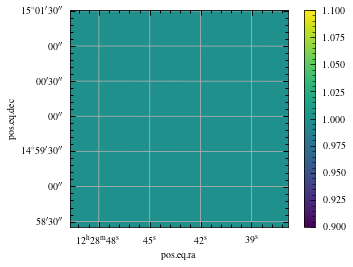

In [4]:
# 
# Show flag mask of FULL image (not the cutout!)
# (1 = good, 0 = bad)
# 
fig, ax = plt.subplots(subplot_kw={"projection": WCS(zband_header_full)})
img = ax.imshow(zband_good_full)
fig.colorbar(img)
plt.show()

mean u: 19.595177
mean g: 59.67002
mean i: 47.9804
mean z: 38.228443

median u: 14.18108
median g: 46.756485
median i: 34.24598
median z: 25.11665


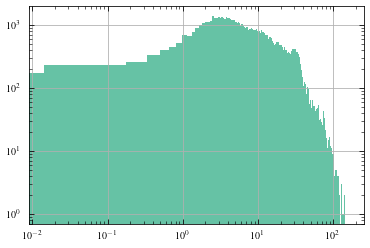

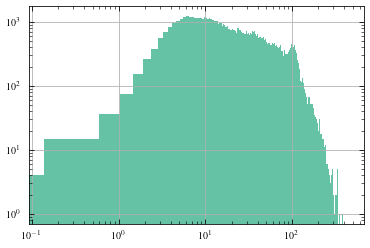

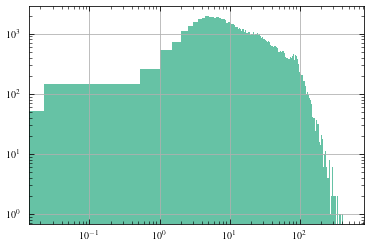

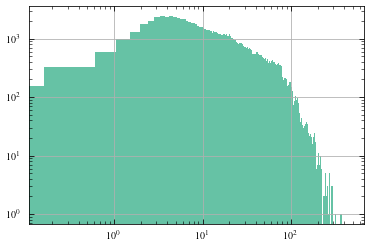

In [5]:
# 
# Determine band that has lowest SNR to use as the reference band
# (in this case, the reference band should be the u-band, but not always this obvious!)
# 
print("mean u:", np.nanmean(uband_data/uband_noise))
print("mean g:", np.nanmean(gband_data/gband_noise))
print("mean i:", np.nanmean(iband_data/iband_noise))
print("mean z:", np.nanmean(zband_data/zband_noise))
print()
print("median u:", np.nanmedian(uband_data/uband_noise))
print("median g:", np.nanmedian(gband_data/gband_noise))
print("median i:", np.nanmedian(iband_data/iband_noise))
print("median z:", np.nanmedian(zband_data/zband_noise))
fig, ax = plt.subplots()
ax.hist(uband_data.flatten() / uband_noise.flatten(), bins=1000)
ax.loglog()
plt.show()
fig, ax = plt.subplots()
ax.hist(gband_data.flatten() / gband_noise.flatten(), bins=1000)
ax.loglog()
plt.show()
fig, ax = plt.subplots()
ax.hist(iband_data.flatten() / iband_noise.flatten(), bins=1000)
ax.loglog()
plt.show()
fig, ax = plt.subplots()
ax.hist(zband_data.flatten() / zband_noise.flatten(), bins=1000)
ax.loglog()
plt.show()

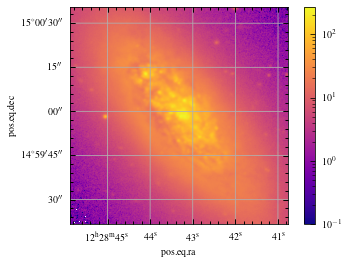

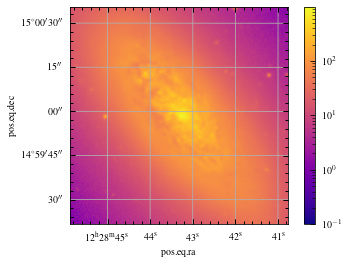

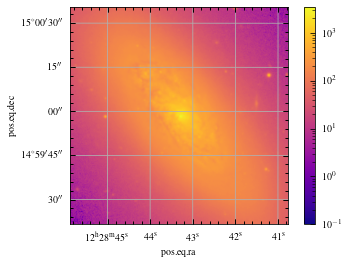

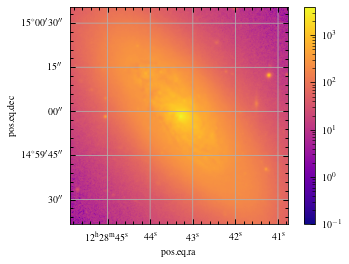

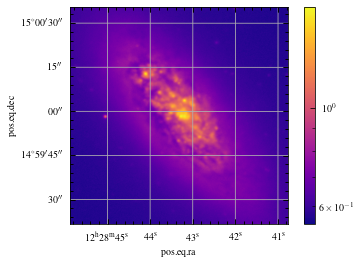

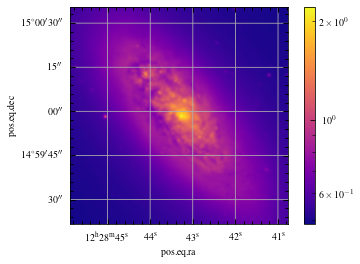

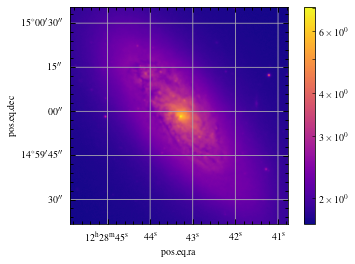

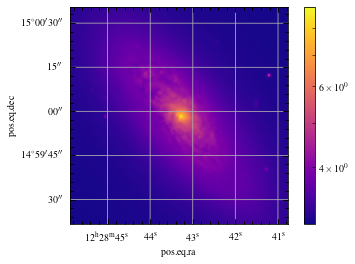

In [6]:
# 
# Show the masked images
# 
fig, ax = plt.subplots(subplot_kw={"projection": uband_wcs})
img = ax.imshow(uband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": gband_wcs})
img = ax.imshow(gband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": iband_wcs})
img = ax.imshow(iband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": zband_wcs})
img = ax.imshow(zband_data, norm=mpl.colors.LogNorm(vmin=1e-1), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": uband_wcs})
img = ax.imshow(uband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": gband_wcs})
img = ax.imshow(gband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": iband_wcs})
img = ax.imshow(iband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()
fig, ax = plt.subplots(subplot_kw={"projection": zband_wcs})
img = ax.imshow(zband_noise, norm=mpl.colors.LogNorm(), cmap="plasma")
fig.colorbar(img)
plt.show()

Reference data array shape: (398, 398)
Number of pixels to Voronoi-bin: 158404
Compiling bin accretion algorithm
Compiling voronoi tesselation algorithm
Bin-accretion done in 2.60 minutes
It took 2.61 minutes to finish Voronoi-binning!


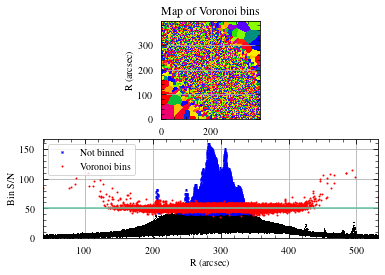

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/IC3392/IC3392_vorbin_SNR50_In+Out.pkl


In [7]:
# 
# Specify reference arrays for Voronoi binning.
# The resulting binning pattern will be applied across all bands (see next cell)
# 
ref_data = uband_data
ref_noise = uband_noise
ref_wcs = uband_wcs
# 
print("Reference data array shape:", np.shape(ref_data))
x_coords, y_coords = np.meshgrid(np.arange(uband_data.shape[1]), np.arange(uband_data.shape[0]))
isgood_vorbin = np.isfinite(ref_data) & np.isfinite(ref_noise)
# 
# Set Voronoi binning SNR target
# (N.B. This should be > your desired minimum SNR)
# 
SNR_TARGET = 50
# 
# Voronoi binning of reference data and noise using JIT-compiled vorbin code
# 
print("Number of pixels to Voronoi-bin:", np.sum(np.isfinite(x_coords[isgood_vorbin])))
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = fv.voronoi_2d_binning(
    x_coords[isgood_vorbin],
    y_coords[isgood_vorbin],
    ref_data[isgood_vorbin],
    ref_noise[isgood_vorbin],
    targetSN=SNR_TARGET,
    pixelsize=1,
    cvt=False,  # not supported by fast_vorbin yet
    quiet=True,
    wvt=False,  # not supported by fast_vorbin yet
    sn_func=None,  # must use "None" (default SNR function). Custom functions not supported by fast_vorbin yet
)
# 
# Save inputs and raw outputs of Voronoi binning
# (We have to save the "wcs.array_shape" attribute since it does not pickle properly)
# 
vorbin_outfile = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_In+Out.pkl"
with open(vorbin_outfile, "wb") as f:
    dill.dump(
        {
            "x_coords": x_coords,
            "y_coords": y_coords,
            "signal": ref_data,
            "noise": ref_noise,
            "isgood_vorbin": isgood_vorbin,
            "snr_target": SNR_TARGET,
            "binNum": binNum,
            "xNode": xNode,
            "yNode": yNode,
            "xBar": xBar,
            "yBar": yBar,
            "sn": sn,
            "nPixels": nPixels,
            "scale": scale,
            "wcs": ref_wcs,
            "wcs_array_shape": ref_wcs.array_shape,
        },
        f,
    )
print(f"Pickled {vorbin_outfile}")

In [8]:
#
# Assign each pixel to its Voronoi bin. Note that we cannot simply reshape the array since
# there may be holes in our input data!
#
# (This may take some time for very large images since Python loops are slow. Can be sped
# up using numba but all arrays MUST be flattened to 1D first. Can also use multiprocessing to
# parallelize each for loop. Contact me if you need help with implementing any of this.)
#
print("Making binNum_arr")
binNum_arr = np.zeros(ref_data.shape) * np.nan  # will specify the Voronoi bin of each pixel
for i, (x, y) in enumerate(zip(x_coords[isgood_vorbin], y_coords[isgood_vorbin])):
    binNum_arr[y, x] = binNum[i]  # binNum has same length as coords
#
# Bin the data and noise according to the Voronoi bins
#
uband_data_vorbinned = np.zeros(uband_data.shape) * np.nan
gband_data_vorbinned = np.zeros(gband_data.shape) * np.nan
iband_data_vorbinned = np.zeros(iband_data.shape) * np.nan
zband_data_vorbinned = np.zeros(zband_data.shape) * np.nan
uband_noise_vorbinned = np.zeros(uband_noise.shape) * np.nan
gband_noise_vorbinned = np.zeros(gband_noise.shape) * np.nan
iband_noise_vorbinned = np.zeros(iband_noise.shape) * np.nan
zband_noise_vorbinned = np.zeros(zband_noise.shape) * np.nan
px_per_bin = np.zeros(uband_data.shape) * np.nan  # all data/noise should have same shape
print("Assigning SNRs to bins")
for i in np.unique(binNum):
    bin_idx = binNum_arr == i  # all of these pixels are in the same bin
    uband_data_vorbinned[bin_idx], uband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        uband_data[bin_idx], uband_noise[bin_idx], func=np.nansum
    )
    gband_data_vorbinned[bin_idx], gband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        gband_data[bin_idx], gband_noise[bin_idx], func=np.nansum
    )
    iband_data_vorbinned[bin_idx], iband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        iband_data[bin_idx], iband_noise[bin_idx], func=np.nansum
    )
    zband_data_vorbinned[bin_idx], zband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        zband_data[bin_idx], zband_noise[bin_idx], func=np.nansum
    )
    px_per_bin[bin_idx] = nPixels[i]
# 
# Pickle the results
# 
vorbinned_results_outfile = GALPATH + f"{GALAXY}_vorbin_SNR{SNR_TARGET}_ugizBinned.pkl"
with open(vorbinned_results_outfile, "wb") as f:
    dill.dump(
        {
            "x_coords": x_coords,
            "y_coords": y_coords,
            "wcs": ref_wcs,
            "wcs_array_shape": ref_wcs.array_shape,
            "uband_signal": uband_data_vorbinned,
            "uband_noise": uband_noise_vorbinned,
            "gband_signal": gband_data_vorbinned,
            "gband_noise": gband_noise_vorbinned,
            "iband_signal": iband_data_vorbinned,
            "iband_noise": iband_noise_vorbinned,
            "zband_signal": zband_data_vorbinned,
            "zband_noise": zband_noise_vorbinned,
            "snr_target": SNR_TARGET,  # float or int
            "px_per_bin": px_per_bin,  # 2D array with same shape as coords/signal/noise
            "binNum": binNum,  # 1D array returned by vorbin. Only contains "good" pixels
            "binNum_arr": binNum_arr,  # 2D array with same shape as coords/signal/noise
        },
        f,
    )
print(f"Pickled {vorbinned_results_outfile}")


Making binNum_arr
Assigning SNRs to bins
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/IC3392/IC3392_vorbin_SNR50_ugizBinned.pkl


In [9]:
# 
# Check some statistics
# 
print(len(sn))
print(np.max(binNum))
print(np.min(sn))
print(np.median(sn))
print(np.mean(sn))
print(np.sum(sn < 30) / len(sn))
print()
#
# Check number of pixels (not bins!) that do not meet SNR requirement of 30 (not the same
# as the target SNR of 50!). Some large bins may not meet SNR requirement (e.g., they are
# near the edges of the image) so this statistic will look worse than it actually is. Just
# use this as a sanity check.
# Lookup table notebook will check the actual number of bins that do not meet the SNR
# requirement 
#
u_snr = uband_data_vorbinned/uband_noise_vorbinned
u_snr = u_snr[np.isfinite(u_snr)]
print(np.nanmin(u_snr))
print(np.nanmean(u_snr))
print(np.nanmedian(u_snr))
print(np.nansum(u_snr < 30)/np.sum(np.isfinite(u_snr)))
print()
g_snr = gband_data_vorbinned/gband_noise_vorbinned
g_snr = g_snr[np.isfinite(g_snr)]
print(np.nanmin(g_snr))
print(np.nanmean(g_snr))
print(np.nanmedian(g_snr))
print(np.nansum(g_snr < 30)/np.sum(np.isfinite(g_snr)))
print()
i_snr = iband_data_vorbinned/iband_noise_vorbinned
i_snr = i_snr[np.isfinite(i_snr)]
print(np.nanmin(i_snr))
print(np.nanmean(i_snr))
print(np.nanmedian(i_snr))
print(np.nansum(i_snr < 30)/np.sum(np.isfinite(i_snr)))
print()
z_snr = zband_data_vorbinned/zband_noise_vorbinned
z_snr = z_snr[np.isfinite(z_snr)]
print(np.nanmin(z_snr))
print(np.nanmean(z_snr))
print(np.nanmedian(z_snr))
print(np.nansum(z_snr < 30)/np.sum(np.isfinite(z_snr)))

33930
33929
36.013633434132515
51.54760537255449
56.33070554806003
0.0

36.01363463963354
61.16326219318417
52.470310866402414
0.0

103.04921566854522
191.58445303126962
170.6443682234645
0.0

51.01807990095649
142.71977954239236
129.0247601788372
0.0

40.201583993994475
108.30832850357311
97.96238728171876
0.0
